<a href="https://colab.research.google.com/github/kevinhoffmanglyde/oxfordgenaigroup2/blob/main/Group2EndtoEnd2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Section Overview:#
This section is a model comparision for selection of the models.
To use the selected model in the project for the business, we need to be able to feed in a full dataset, retrain the model based on the new data, and create predictions based on the fresh data and newly trained model.
This section separates the Training and Test data for checking accuracy and loss in order to select the better model for the job.



#Mount the Google Drive

In [1]:
import pandas as pd
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


#Authenticate

In [2]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


#Get the data

In [3]:
df = pd.read_csv('gdrive/MyDrive/Complete_Sales_Data_Final.csv')

#Check the data is there

In [4]:
df.head()

,Country,Month,Store ID,Product ID,GDP Growth Rate,Price Sold,Units Sold,Inflation Rate,Date of Sale,Product Subcategory
0,France,2023-01,7,1,-0.4,98.5,56,1.82,2023-01-01,Mens Jackets
1,France,2023-01,7,1,-0.4,98.5,60,1.82,2023-01-01,Mens Jackets
2,France,2023-01,7,1,-0.4,98.5,56,1.82,2023-01-01,Mens Jackets
3,France,2023-01,7,1,-0.4,98.5,64,1.82,2023-01-01,Mens Jackets
4,France,2023-01,7,1,-0.4,98.5,64,1.82,2023-01-01,Mens Jackets


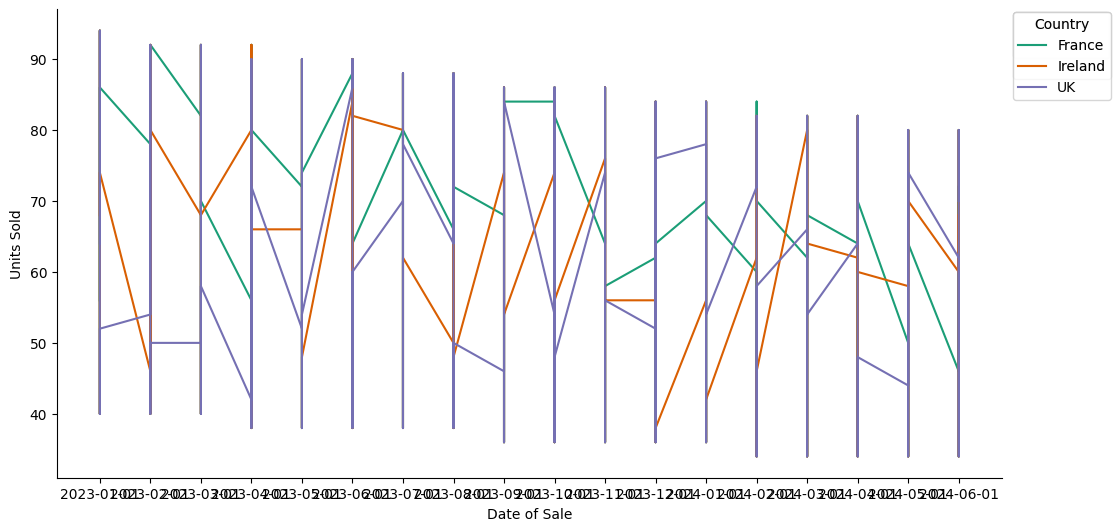

In [6]:
# @title Date of Sale vs Units Sold

from matplotlib import pyplot as plt
import seaborn as sn
def _plot_series(series, series_name, series_index=0):
  palette = list(sn.palettes.mpl_palette('Dark2'))
  xs = series['Date of Sale']
  ys = series['Units Sold']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df.sort_values('Date of Sale', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Country')):
  _plot_series(series, series_name, i)
  fig.legend(title='Country', bbox_to_anchor=(1, 1), loc='upper left')
sn.despine(fig=fig, ax=ax)
plt.xlabel('Date of Sale')
_ = plt.ylabel('Units Sold')

#Can fix the country mapping in the display.
Store ID is important, but country is not because it can be mapped to the store.

<ipython-input-7-7bbc60e62bbc>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sn.violinplot(df, x='Units Sold', y='Country', inner='box', palette='Dark2')


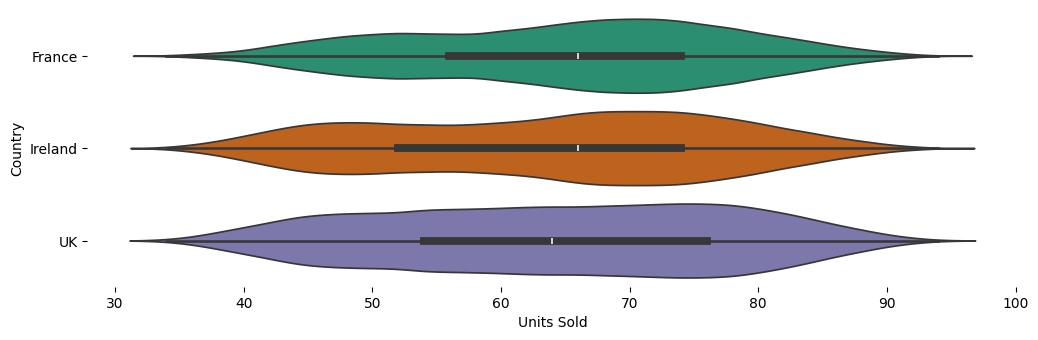

In [7]:
# @title Country vs Units Sold

figsize = (12, 1.2 * len(df['Country'].unique()))
plt.figure(figsize=figsize)
sn.violinplot(df, x='Units Sold', y='Country', inner='box', palette='Dark2')
sn.despine(top=True, right=True, bottom=True, left=True)

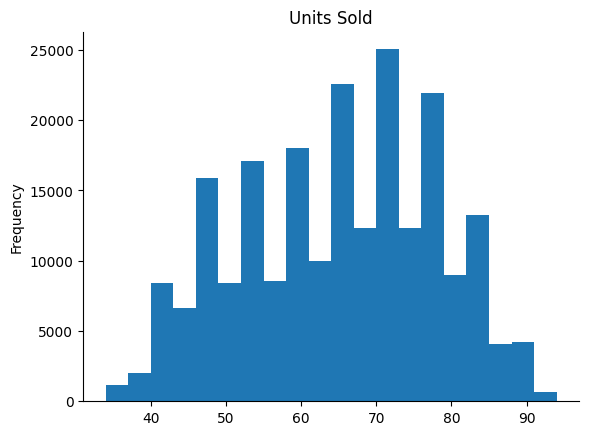

In [8]:
# @title Units Sold

df['Units Sold'].plot(kind='hist', bins=20, title='Units Sold')
plt.gca().spines[['top', 'right',]].set_visible(False)

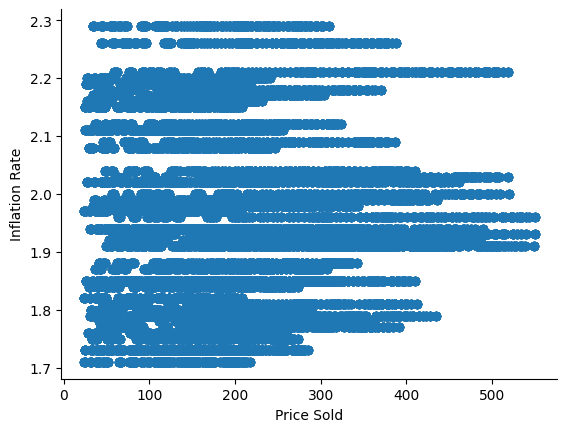

In [9]:
# @title Price Sold vs Inflation Rate
df.plot(kind='scatter', x='Price Sold', y='Inflation Rate', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

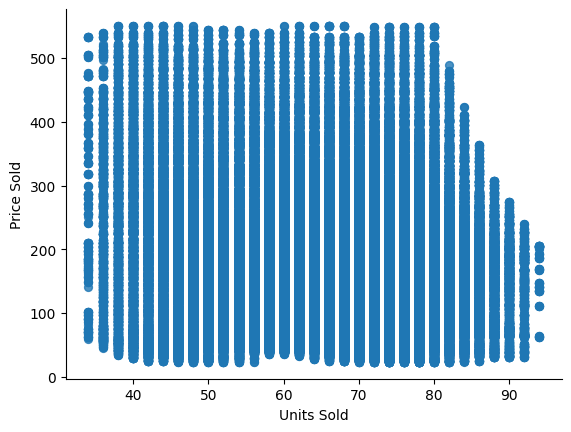

In [10]:
# @title Units Sold vs Price Sold

df.plot(kind='scatter', x='Units Sold', y='Price Sold', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

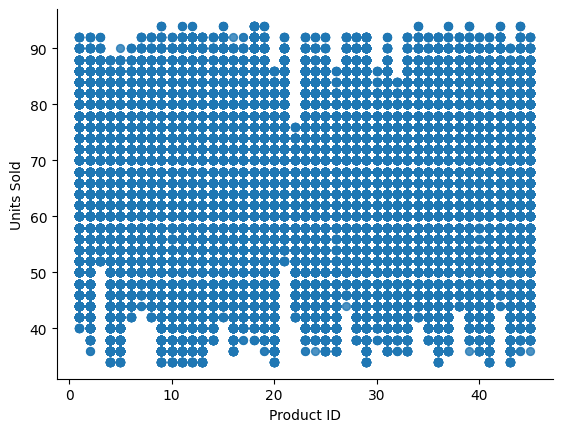

In [11]:
df.plot(kind='scatter', x='Product ID', y='Units Sold', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

##Now examine the data
The biggest worry is that once we get to the testing of the model, using the synthetic data, we may be trying to map the model based on the training data to data that is completely random.
The data we have is for all of 2023 and up to the end of April 2024.  The method for creating the synthetic data is included in a document, but in short - the Price Sold and Units Sold are created by tracking the Inflation Rate.  Then the units sold are slightly randomised to imitate freedom of choice.

In [12]:
import pandas as pd
import numpy as np
import datetime
datetosplit = 202403
reference_date = datetime.date(1970, 1, 1)
# train_test_split is used to easily divide data into training and testing sets.
from sklearn.model_selection import train_test_split
# LinearRegression is the model we'll be using from scikit-learn.
from sklearn.linear_model import LinearRegression
# mean_absolute_error and mean_squared_error are metrics to evaluate our model.
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# matplotlib.pyplot is used for plotting graphs.
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor

The store ID is unique, and there are 3 stores per country.
The price per product should match for each store in the country on a given date.

In [13]:
df = df.sort_values(["Date of Sale"], ascending = (True)) # order the data by year, month, day in ascending order.
df.head() # check the data again by viewing the first 5 rows

,Country,Month,Store ID,Product ID,GDP Growth Rate,Price Sold,Units Sold,Inflation Rate,Date of Sale,Product Subcategory
0,France,2023-01,7,1,-0.40,98.5,56,1.82,2023-01-01,Mens Jackets
46014,France,2023-01,9,29,0.17,179.5,84,1.82,2023-01-01,Womens Skirts
46013,France,2023-01,9,29,0.17,179.5,92,1.82,2023-01-01,Womens Skirts
46012,France,2023-01,9,29,0.17,179.5,90,1.82,2023-01-01,Womens Skirts
46011,France,2023-01,9,29,0.17,179.5,88,1.82,2023-01-01,Womens Skirts


In [14]:
df2 = df.sort_values(["Date of Sale"], ascending = (False)) # order the data by year, month, day in ascending order.
df2.head() # check the data again by viewing the first 5 rows

,Country,Month,Store ID,Product ID,GDP Growth Rate,Price Sold,Units Sold,Inflation Rate,Date of Sale,Product Subcategory
221534,UK,2024-06,6,45,-0.45,505.61,70,1.91,2024-06-01,Womens Shoes
108243,Ireland,2024-06,1,21,1.93,407.63,68,1.96,2024-06-01,Womens Tops
124659,Ireland,2024-06,2,31,1.22,436.95,70,1.96,2024-06-01,Dressses
108232,Ireland,2024-06,1,21,1.93,407.63,66,1.96,2024-06-01,Womens Tops
108231,Ireland,2024-06,1,21,1.93,407.63,70,1.96,2024-06-01,Womens Tops


A little surprised by the Max Units Sold.

In [15]:
df['Date of Sale']

0         2023-01-01
46014     2023-01-01
46013     2023-01-01
46012     2023-01-01
46011     2023-01-01
             ...    
178834    2024-06-01
178833    2024-06-01
178832    2024-06-01
178840    2024-06-01
221534    2024-06-01
Name: Date of Sale, Length: 221535, dtype: object

In [16]:
df.describe()

,Store ID,Product ID,GDP Growth Rate,Price Sold,Units Sold,Inflation Rate
count,221535.000000,221535.000000,221535.000000,221535.000000,221535.000000,221535.000000
mean,5.000000,23.000000,-0.018219,211.408857,64.455486,1.961255
std,2.581995,12.987202,1.153344,110.652063,12.968493,0.148290
min,1.000000,1.000000,-2.000000,23.500000,34.000000,1.710000
25%,3.000000,12.000000,-1.020000,127.400000,54.000000,1.850000
50%,5.000000,23.000000,-0.030000,197.780000,66.000000,1.940000
75%,7.000000,34.000000,1.000000,281.660000,74.000000,2.080000
max,9.000000,45.000000,2.000000,550.190000,94.000000,2.290000


In [17]:
print(df['Units Sold'])

0         56
46014     84
46013     92
46012     90
46011     88
          ..
178834    60
178833    56
178832    52
178840    46
221534    70
Name: Units Sold, Length: 221535, dtype: int64


In [18]:
df.isnull().sum()

Country                0
Month                  0
Store ID               0
Product ID             0
GDP Growth Rate        0
Price Sold             0
Units Sold             0
Inflation Rate         0
Date of Sale           0
Product Subcategory    0
dtype: int64

Looks like no Nulls, which is expected for our synthetic data.

In [19]:
df['Units Sold'].isna().sum()

0

Tidy up some of the data columns just in case.
Doing a drop method rather than inplace replacement.

In [20]:
#clean up any nulls that might come through in real data
df = df.dropna(subset=['Store ID', 'Product ID', 'Date of Sale'])

##Check out the distribution of the data

In [21]:
unique_store = df['Store ID'].nunique()
unique_product = df['Product ID'].nunique()
#unique_product_cat = df['Product Category'].nunique()
unique_country = df['Country'].nunique()
unique_pricesold = df['Price Sold'].nunique()
unique_dates = df['Date of Sale'].nunique()

print("Distinct Stores:", unique_store)
print("Distinct Products:", unique_product)
#print("Distinct Product Categories:", unique_product_cat)
print("Distinct Countries:", unique_country)
print("Distinct Prices:", unique_pricesold)
print("Distinct Dates:", unique_dates)

Distinct Stores: 9
Distinct Products: 45
Distinct Countries: 3
Distinct Prices: 6122
Distinct Dates: 18


Data above looks OK.
Stores, Products, Categories and Countries look like the specifications in the data.
Prices have a different value for each country and each product for each month.  642 is a good ballpark.

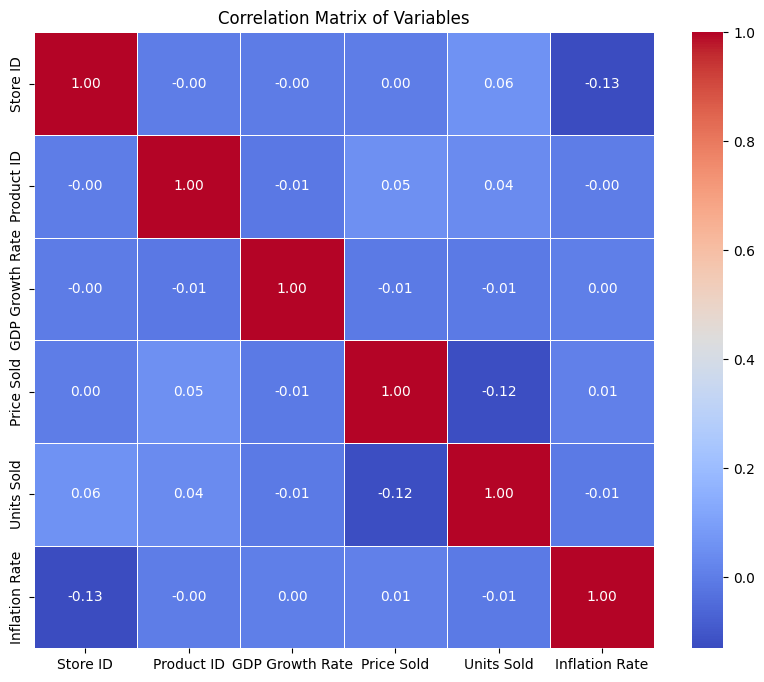

In [22]:
# Calculating the correlation matrix
correlation_matrix = df.corr(numeric_only=True)
#numeric_only is a new variable for the correlation matrix.
#If we want to include Country, we would have to include one-hot-encoding on Country because it is a string and will not fit in a correlation matrix.
# Initializes a new figure for plotting with a specified size to ensure the heatmap is large enough to read.
plt.figure(figsize=(10, 8))

# Creates a heatmap to visualize the correlation matrix.
# - annot=True displays the correlation coefficient values inside the squares.
# - cmap='coolwarm' chooses a color map that visually represents positive (warm) and negative (cool) correlations.
# - fmt=".2f" formats the annotation strings to display only two decimal places.
# - linewidths=.5 adds lines between squares to separate them visually.
sn.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)

# Sets the title of the heatmap for clarity.
plt.title('Correlation Matrix of Variables')

# Displays the plot. Without this, the figure would not be shown in a notebook.
plt.show()

Inflation rate and store ID have the biggest corelation to Units Sold.  That's expected.  Though Inflation rate is supposed to influence Price Sold much more strongly.

In [23]:
#df['Date of Sale'] = pd.to_datetime(df['Date of Sale'], format='%d/%m/%Y')
df['Date of Sale'] = pd.to_datetime(df['Date of Sale'])
min_sale_date = df['Date of Sale'].min()
max_sale_date = df['Date of Sale'].max()

print("Minimum date:", min_sale_date)
print("Maximum date:", max_sale_date)

Minimum date: 2023-01-01 00:00:00
Maximum date: 2024-06-01 00:00:00


Date range as expected.

#Date issues##
Since we are trying to predict future demand, this suggests that when we divide the Training and Test data, we need to do this on a date basis.  Including dates in the training set that should appear in the test set is not desired.  When using this on real data in production, the future dates will all be empty.

So, selecting out test and train data set should be on dates rather than simply a percentage of the dataset.  I have used most of the data for training, but left out 3 months of the 15 as test data.

Once the data split is completed, I dropped the Date of Sale and aggregated the data to the month.

#Split the data into Past and "Future"

In [24]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import numpy as np


Convert to a DateTime - this is used to extract year and month values

#Set the monthly values
Price Sold
Inflation Rate
Units Sold
###Ignoring GDP Growth Rate as that is going to be dropped

In [38]:
df['YearMonth'] = df['Date of Sale'].dt.year*100+df['Date of Sale'].dt.month
X = df[['Store ID', 'GDP Growth Rate', 'Inflation Rate', 'Price Sold', 'Product ID', 'YearMonth', 'Country', 'Product Subcategory']]
dfa = df[['Store ID', 'GDP Growth Rate', 'Inflation Rate', 'Price Sold', 'Product ID', 'YearMonth', 'Units Sold', 'Country', 'Product Subcategory']]
print(dfa)

        Store ID  GDP Growth Rate  Inflation Rate  Price Sold  Product ID  \
0              7            -0.40            1.82       98.50           1   
46014          9             0.17            1.82      179.50          29   
46013          9             0.17            1.82      179.50          29   
46012          9             0.17            1.82      179.50          29   
46011          9             0.17            1.82      179.50          29   
...          ...              ...             ...         ...         ...   
178834         5             1.09            1.91      509.39          19   
178833         5             1.09            1.91      509.39          19   
178832         5             1.09            1.91      509.39          19   
178840         6            -0.29            1.91      519.12          19   
221534         6            -0.45            1.91      505.61          45   

        YearMonth  Units Sold Country Product Subcategory  
0          2023

In [39]:

# Assuming dfa is your original DataFrame
units_sold_aggregate = dfa.groupby([
    'Store ID', 'GDP Growth Rate', 'Inflation Rate', 'Price Sold', 'Product ID', 'YearMonth', 'Country', 'Product Subcategory'
])['Units Sold'].sum().reset_index()
units_sold_aggregate.rename(columns={'Units Sold': 'Units Sold Aggregate'}, inplace=True)
#units_sold_aggregate = pd.get_dummies(units_sold_aggregate, columns=['Country', 'Product Subcategory', 'Store ID', 'Product ID'], drop_first=False)

price_sold_average = dfa.groupby([
    'Store ID', 'GDP Growth Rate', 'Inflation Rate', 'Product ID', 'YearMonth', 'Country', 'Product Subcategory'
])['Price Sold'].mean().reset_index()
price_sold_average.rename(columns={'Price Sold': 'Average Price Sold'}, inplace=True)
#price_sold_average = pd.get_dummies(price_sold_average, columns=['Country', 'Product Subcategory', 'Store ID', 'Product ID'], drop_first=False)
#inflation rate is not necessary as it is the same for each monthly aggregate.

result = pd.merge(units_sold_aggregate, price_sold_average, on=[
    'Store ID', 'GDP Growth Rate', 'Product ID',
    'YearMonth', 'Country', 'Inflation Rate','Country', 'Product Subcategory'
], how='inner')

In [40]:
print(result)

      Store ID  GDP Growth Rate  Inflation Rate  Price Sold  Product ID  \
0            1            -2.00            1.85      175.86          31   
1            1            -2.00            2.21      496.69          18   
2            1            -2.00            2.26      208.75          32   
3            1            -1.99            1.73      134.79          44   
4            1            -1.96            1.85      258.37          44   
...        ...              ...             ...         ...         ...   
7285         9             1.97            1.79      415.21          45   
7286         9             1.97            1.84       98.62          13   
7287         9             1.97            1.93      490.38          27   
7288         9             1.97            2.11      151.24          44   
7289         9             1.98            1.82       78.00          43   

      YearMonth  Country Product Subcategory  Units Sold Aggregate  \
0        202303  Ireland     

#One-Hot
This is an attempt to improve the linear lasso regression as it is sensitive to numbers in the features.  To improve this while not forcing everything into a scale, I will one-hot the Product ID, the Store ID, the Country and the Product Subcategory.  Once we get to the BI layer, they can be reassembled.
In fact, only the Store ID and Product ID need to be reassembled.

In [41]:
result = pd.get_dummies(result, columns=['Store ID', 'Country', 'Product Subcategory', 'Product ID'], drop_first=False)

In [42]:
print(result)

      GDP Growth Rate  Inflation Rate  Price Sold  YearMonth  \
0               -2.00            1.85      175.86     202303   
1               -2.00            2.21      496.69     202405   
2               -2.00            2.26      208.75     202312   
3               -1.99            1.73      134.79     202302   
4               -1.96            1.85      258.37     202401   
...               ...             ...         ...        ...   
7285             1.97            1.79      415.21     202402   
7286             1.97            1.84       98.62     202306   
7287             1.97            1.93      490.38     202406   
7288             1.97            2.11      151.24     202303   
7289             1.98            1.82       78.00     202301   

      Units Sold Aggregate  Average Price Sold  Store ID_1  Store ID_2  \
0                     1772              175.86        True       False   
1                     1426              496.69        True       False   
2        

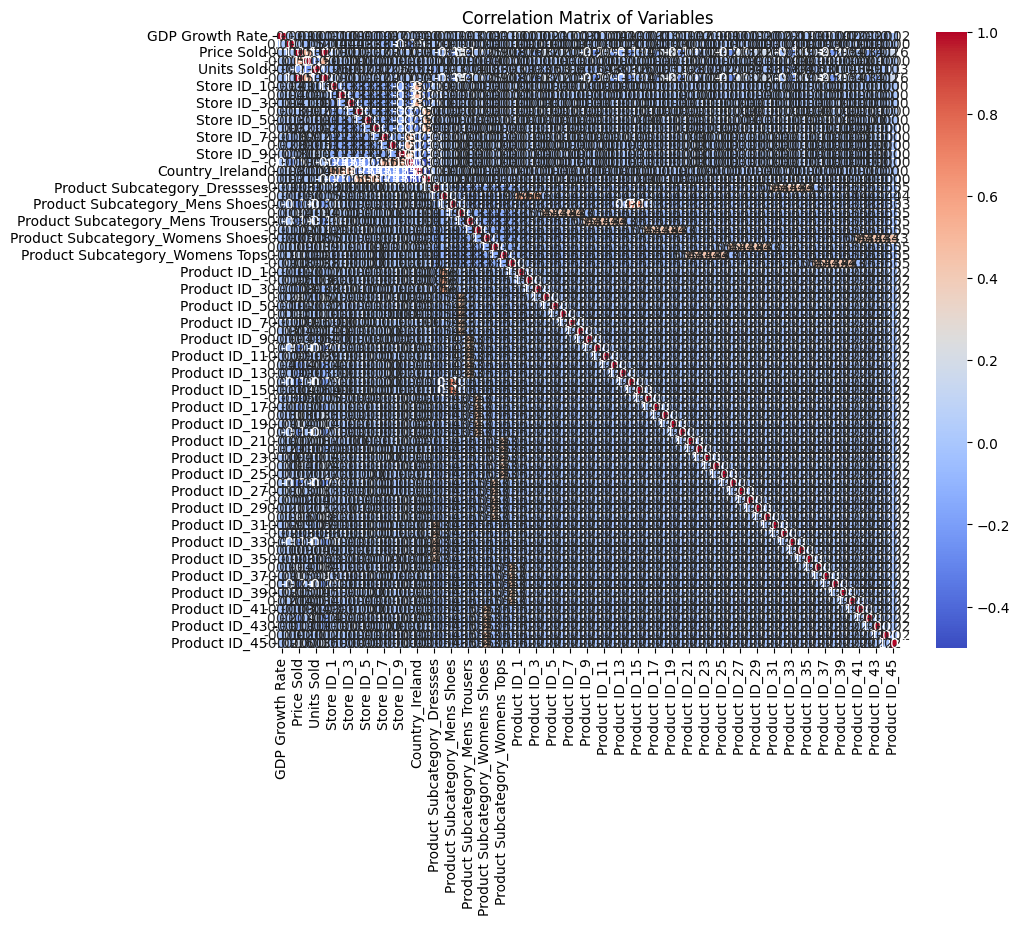

In [53]:
# Calculating the correlation matrix
correlation_matrix = result.corr(numeric_only=True)
#numeric_only is a new variable for the correlation matrix.
#If we want to include Country, we would have to include one-hot-encoding on Country because it is a string and will not fit in a correlation matrix.
# Initializes a new figure for plotting with a specified size to ensure the heatmap is large enough to read.
plt.figure(figsize=(10, 8))

# Creates a heatmap to visualize the correlation matrix.
# - annot=True displays the correlation coefficient values inside the squares.
# - cmap='coolwarm' chooses a color map that visually represents positive (warm) and negative (cool) correlations.
# - fmt=".2f" formats the annotation strings to display only two decimal places.
# - linewidths=.5 adds lines between squares to separate them visually.
sn.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)

# Sets the title of the heatmap for clarity.
plt.title('Correlation Matrix of Variables')
plt.show()

#Drop the columns we won't be using and rename the aggregates

In [43]:
result.rename(columns={'Units Sold Aggregate': 'Units Sold'}, inplace=True)
result.rename(columns={'Average Price Sold': 'Price Sold'}, inplace=True)

In [44]:
print(result)
Y = result['Units Sold']
X =  result.drop(columns='Units Sold')

      GDP Growth Rate  Inflation Rate  Price Sold  YearMonth  Units Sold  \
0               -2.00            1.85      175.86     202303        1772   
1               -2.00            2.21      496.69     202405        1426   
2               -2.00            2.26      208.75     202312        1386   
3               -1.99            1.73      134.79     202302        2470   
4               -1.96            1.85      258.37     202401        2472   
...               ...             ...         ...        ...         ...   
7285             1.97            1.79      415.21     202402        1872   
7286             1.97            1.84       98.62     202306        2152   
7287             1.97            1.93      490.38     202406        2144   
7288             1.97            2.11      151.24     202303        2284   
7289             1.98            1.82       78.00     202301        2212   

      Price Sold  Store ID_1  Store ID_2  Store ID_3  Store ID_4  ...  \
0         175.

In [45]:
X.describe()

,GDP Growth Rate,Inflation Rate,Price Sold,YearMonth,Price Sold
count,7290.000000,7290.000000,7290.000000,7290.000000,7290.000000
mean,-0.018107,1.960556,211.307103,202338.833333,211.307103
std,1.153549,0.148514,110.714326,45.826779,110.714326
min,-2.000000,1.710000,23.500000,202301.000000,23.500000
25%,-1.020000,1.850000,127.242500,202305.000000,127.242500
50%,-0.030000,1.940000,197.500000,202309.500000,197.500000
75%,1.000000,2.080000,281.540000,202402.000000,281.540000
max,2.000000,2.290000,550.190000,202406.000000,550.190000


#Set the datesplit value
In a productionised system this would have to be dynamic

In [46]:
#split_date = pd.to_datetime(datetosplit)
# Data before the split date
datetosplit = 202402
X_Train = X[X['YearMonth'] <= datetosplit]

print("Data before the split date:")
print(X_Train)



Data before the split date:
      GDP Growth Rate  Inflation Rate  Price Sold  YearMonth  Price Sold  \
0               -2.00            1.85      175.86     202303      175.86   
2               -2.00            2.26      208.75     202312      208.75   
3               -1.99            1.73      134.79     202302      134.79   
4               -1.96            1.85      258.37     202401      258.37   
7               -1.96            2.11      198.83     202305      198.83   
...               ...             ...         ...        ...         ...   
7281             1.96            1.71       67.33     202302       67.33   
7285             1.97            1.79      415.21     202402      415.21   
7286             1.97            1.84       98.62     202306       98.62   
7288             1.97            2.11      151.24     202303      151.24   
7289             1.98            1.82       78.00     202301       78.00   

      Store ID_1  Store ID_2  Store ID_3  Store ID_4  Store

In [47]:
print(X[X['YearMonth'] > datetosplit])

      GDP Growth Rate  Inflation Rate  Price Sold  YearMonth  Price Sold  \
1               -2.00            2.21      496.69     202405      496.69   
5               -1.96            1.92      139.67     202403      139.67   
6               -1.96            1.92      323.47     202404      323.47   
13              -1.92            1.96      482.03     202406      482.03   
23              -1.87            1.96      363.15     202406      363.15   
...               ...             ...         ...        ...         ...   
7278             1.93            1.94      262.42     202404      262.42   
7282             1.96            2.00      191.99     202405      191.99   
7283             1.96            2.02      310.31     202403      310.31   
7284             1.96            2.02      407.47     202403      407.47   
7287             1.97            1.93      490.38     202406      490.38   

      Store ID_1  Store ID_2  Store ID_3  Store ID_4  Store ID_5  ...  \
1           Tr

X_Train is set above

In [54]:
X_Test = X[X['YearMonth'] > datetosplit]
Y_Train = Y[result['YearMonth'] <= datetosplit]
Y_Test = Y[result['YearMonth'] > datetosplit]

Y_Test = Y_Test.drop(columns=['YearMonth'])
print("Data on or after the split date:")
print(X_Test)

print("Data before the split date:")
print(Y_Train)

print("Data on or after the split date:")
print(Y_Test)

Data on or after the split date:
      GDP Growth Rate  Inflation Rate  Price Sold  YearMonth  Price Sold  \
1               -2.00            2.21      496.69     202405      496.69   
5               -1.96            1.92      139.67     202403      139.67   
6               -1.96            1.92      323.47     202404      323.47   
13              -1.92            1.96      482.03     202406      482.03   
23              -1.87            1.96      363.15     202406      363.15   
...               ...             ...         ...        ...         ...   
7278             1.93            1.94      262.42     202404      262.42   
7282             1.96            2.00      191.99     202405      191.99   
7283             1.96            2.02      310.31     202403      310.31   
7284             1.96            2.02      407.47     202403      407.47   
7287             1.97            1.93      490.38     202406      490.38   

      Store ID_1  Store ID_2  Store ID_3  Store ID_4  

#Linear Regression model
Try to tune the Lasso alpha automatically, then fit using the best alpha.
Once concern is that the Lasso sensitive to the scale of input features.

In [55]:
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
# Creating an instance of the LinearRegression model.

lasso_cv = LassoCV(alphas=[0.001, 0.01, 0.1, 1, 10], cv=5)
lasso_cv.fit(X_Train, Y_Train)
best_alpha = lasso_cv.alpha_
# Lasso Regression
modelLR = Lasso(alpha=best_alpha)  # Alpha is a hyperparameter for L1 regularization
#modelLR = LinearRegression(alpha=0.1)
# Fitting the model to the training data. This is where the model learns the relationship between features and target.
modelLR.fit(X_Train, Y_Train)


Lasso(alpha=10.0)

In [56]:
# Cross-validating the model
scores = cross_val_score(modelLR, X_Train, Y_Train, cv=3)
print(f"Cross-validated R² scores: {scores}")
print(f"Average R² score: {np.mean(scores)}")

Cross-validated R² scores: [0.02101583 0.01687138 0.02133139]
Average R² score: 0.019739532492855982


In [57]:
# Use the trained model to make predictions on the testing set.
predictionsLR = modelLR.predict(X_Test)

# Evaluating the model's performance by comparing actual values (y_test) vs predicted values (predictions).
# MAE is the mean absolute error, MSE is the mean squared error, and RMSE is the square root of MSE.

# Evaluating the model
mse = mean_squared_error(Y_Test, predictionsLR)
r2 = r2_score(Y_Test, predictionsLR)
print('MAE:', mean_absolute_error(Y_Test, predictionsLR))
print('MSE:', mean_squared_error(Y_Test, predictionsLR))
print('RMSE:', np.sqrt(mean_squared_error(Y_Test, predictionsLR)))
print(f"R² score: {r2}")

MAE: 296.293843901835
MSE: 120941.86022467376
RMSE: 347.7669625261631
R² score: 0.009729627732692148


In [58]:
X_Test.describe()

,GDP Growth Rate,Inflation Rate,Price Sold,YearMonth,Price Sold
count,1620.000000,1620.000000,1620.000000,1620.000000,1620.000000
mean,-0.031358,1.973333,303.864623,202404.500000,303.864623
std,1.164745,0.082116,127.379666,1.118379,127.379666
min,-2.000000,1.910000,50.390000,202403.000000,50.390000
25%,-1.060000,1.920000,199.525000,202403.750000,199.525000
50%,-0.085000,1.935000,317.980000,202404.500000,317.980000
75%,1.010000,2.005000,408.912500,202405.250000,408.912500
max,2.000000,2.210000,550.190000,202406.000000,550.190000


#Reset the indices and merge the datasets

This is the Actual values.

In [59]:
from datetime import datetime
#X_Test['Date of Sale'] = pd.to_datetime(X_Test[['Year', 'Month', 'Day']])
X_Test.reset_index(drop=True, inplace=True)
Y_Test.reset_index(drop=True, inplace=True)
merged_df = pd.merge(X_Test, Y_Test, left_index=True, right_index=True)
print(merged_df)
merged_df.describe()


      GDP Growth Rate  Inflation Rate  Price Sold  YearMonth  Price Sold  \
0               -2.00            2.21      496.69     202405      496.69   
1               -1.96            1.92      139.67     202403      139.67   
2               -1.96            1.92      323.47     202404      323.47   
3               -1.92            1.96      482.03     202406      482.03   
4               -1.87            1.96      363.15     202406      363.15   
...               ...             ...         ...        ...         ...   
1615             1.93            1.94      262.42     202404      262.42   
1616             1.96            2.00      191.99     202405      191.99   
1617             1.96            2.02      310.31     202403      310.31   
1618             1.96            2.02      407.47     202403      407.47   
1619             1.97            1.93      490.38     202406      490.38   

      Store ID_1  Store ID_2  Store ID_3  Store ID_4  Store ID_5  ...  \
0           Tr

,GDP Growth Rate,Inflation Rate,Price Sold,YearMonth,Price Sold,Units Sold
count,1620.000000,1620.000000,1620.000000,1620.000000,1620.000000,1620.000000
mean,-0.031358,1.973333,303.864623,202404.500000,303.864623,1832.539506
std,1.164745,0.082116,127.379666,1.118379,127.379666,349.579142
min,-2.000000,1.910000,50.390000,202403.000000,50.390000,1106.000000
25%,-1.060000,1.920000,199.525000,202403.750000,199.525000,1530.000000
50%,-0.085000,1.935000,317.980000,202404.500000,317.980000,1878.000000
75%,1.010000,2.005000,408.912500,202405.250000,408.912500,2116.500000
max,2.000000,2.210000,550.190000,202406.000000,550.190000,2456.000000


#Create the predictions dataframe

In [60]:
df_1d = pd.DataFrame(predictionsLR, columns=['Prediction'])
print(df_1d)

       Prediction
0     1819.307396
1     1859.121863
2     1838.675313
3     1819.093900
4     1831.213750
...           ...
1615  1832.492142
1616  1875.780507
1617  1867.133924
1618  1857.228433
1619  1843.651473

[1620 rows x 1 columns]


#Merge the the predictions

In [61]:
df_1d = pd.DataFrame(predictionsLR, columns=['Prediction'])
merged_df2 = pd.merge(X_Test, df_1d, left_index=True, right_index=True)

print(merged_df2)

      GDP Growth Rate  Inflation Rate  Price Sold  YearMonth  Price Sold  \
0               -2.00            2.21      496.69     202405      496.69   
1               -1.96            1.92      139.67     202403      139.67   
2               -1.96            1.92      323.47     202404      323.47   
3               -1.92            1.96      482.03     202406      482.03   
4               -1.87            1.96      363.15     202406      363.15   
...               ...             ...         ...        ...         ...   
1615             1.93            1.94      262.42     202404      262.42   
1616             1.96            2.00      191.99     202405      191.99   
1617             1.96            2.02      310.31     202403      310.31   
1618             1.96            2.02      407.47     202403      407.47   
1619             1.97            1.93      490.38     202406      490.38   

      Store ID_1  Store ID_2  Store ID_3  Store ID_4  Store ID_5  ...  \
0           Tr

#Merge the actuals and predictions

      GDP Growth Rate  Inflation Rate  Price Sold  YearMonth  Price Sold  \
0               -2.00            2.21      496.69     202405      496.69   
1               -1.96            1.92      139.67     202403      139.67   
2               -1.96            1.92      323.47     202404      323.47   
3               -1.92            1.96      482.03     202406      482.03   
4               -1.87            1.96      363.15     202406      363.15   
...               ...             ...         ...        ...         ...   
1615             1.93            1.94      262.42     202404      262.42   
1616             1.96            2.00      191.99     202405      191.99   
1617             1.96            2.02      310.31     202403      310.31   
1618             1.96            2.02      407.47     202403      407.47   
1619             1.97            1.93      490.38     202406      490.38   

      Store ID_1  Store ID_2  Store ID_3  Store ID_4  Store ID_5  ...  \
0           Tr

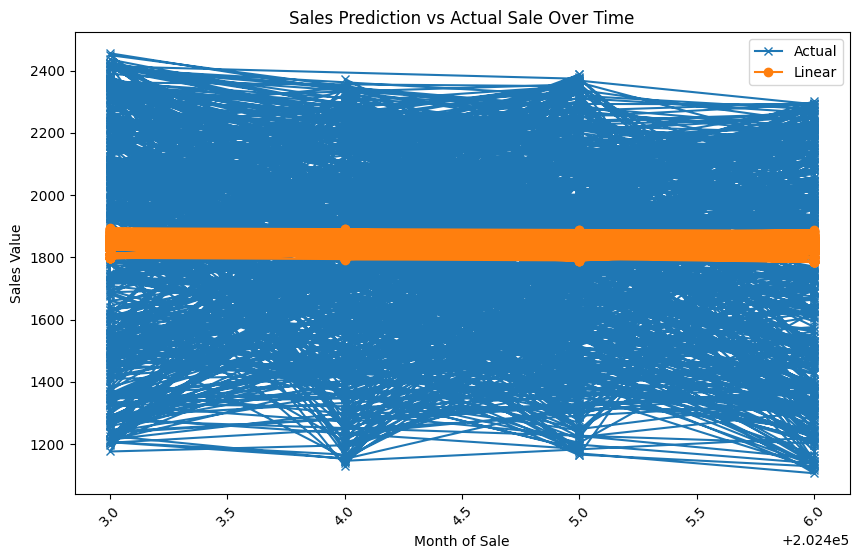

In [62]:
print(merged_df)
#print(filtered_df2)
plt.figure(figsize=(10, 6))  # Set the figure size= modelLR.predict(X_Test)
#print(filtered_df)
plt.plot(merged_df['YearMonth'] , merged_df['Units Sold'], label='Actual', marker='x')  # Plot Sales Prediction
plt.plot(merged_df2['YearMonth'] ,  merged_df2['Prediction'], label='Linear', marker='o')  # Plot Sales Prediction
# Adding titles and labels
plt.title('Sales Prediction vs Actual Sale Over Time')
plt.xlabel('Month of Sale')
plt.ylabel('Sales Value')
plt.xticks(rotation=45)  # Rotate date labels for better readability
#plt.ylim(0, 150)

# Adding legend
plt.legend()

# Show the plot
plt.show()
#X_Test = X_Test.drop(columns=['Date of Sale'])

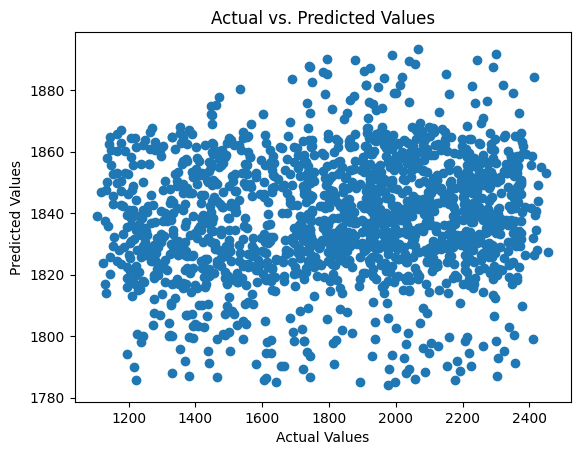

In [63]:
# Plotting actual vs predicted values to visualize how well our model is performing.
plt.scatter(Y_Test, predictionsLR)
plt.xlabel('Actual Values')  # X-axis label
plt.ylabel('Predicted Values')  # Y-axis label
plt.title('Actual vs. Predicted Values')  # Graph title
plt.show()  # Display the plot

#Random Forest
Trying to get the program to tune its own model.
This one takes a significant amount of time.

In [64]:
from sklearn.model_selection import train_test_split, GridSearchCV
# Set up the grid of parameters to search
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10],
    'max_features': ['auto', 'sqrt', 'log2']
}
# Create a RandomForestRegressor object
rf = RandomForestRegressor(random_state=42)
# Set up GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, scoring='accuracy', verbose=2, n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(X_Train, Y_Train)

# Best parameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print("Best parameters:", best_params)
print("Best model:", best_model)

#best_params = grid_search.best_params_
optimized_rf = RandomForestRegressor(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    max_features=best_params['max_features'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    random_state=42
)


optimized_rf.fit(X_Train, Y_Train)

# Make predictions and evaluate the model
from sklearn.metrics import mean_squared_error
# Use the trained model to make predictions on the testing set.
predictionsRF = optimized_rf.predict(X_Test)
#predictionsRF = best_model.predict(X_Test)
mse = mean_squared_error(Y_Test, predictionsRF)
print(f"Mean Squared Error: {mse}")


Fitting 3 folds for each of 324 candidates, totalling 972 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan 

Best parameters: {'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best model: RandomForestRegressor(max_features='auto', random_state=42)


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


Mean Squared Error: 110972.94651753086


In [65]:
# Evaluating the model's performance by comparing actual values (y_test) vs predicted values (predictions).
# MAE is the mean absolute error, MSE is the mean squared error, and RMSE is the square root of MSE.
# Evaluating the model
mseRF = mean_squared_error(Y_Test, predictionsRF)
r2RF = r2_score(Y_Test, predictionsRF)
print('MAE:', mean_absolute_error(Y_Test, predictionsRF))
print('MSE:', mean_squared_error(Y_Test, predictionsRF))
print('RMSE:', np.sqrt(mean_squared_error(Y_Test, predictionsRF)))
print(f"R² score: {r2RF}")

MAE: 280.1353086419753
MSE: 110972.94651753086
RMSE: 333.1260219759646
R² score: 0.09135496299323809


#Scatter plot of the Predictions v Actual

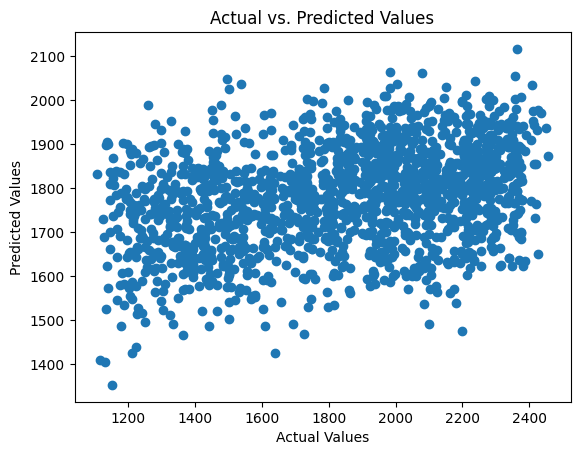

In [66]:
# Plotting actual vs predicted values to visualize how well our model is performing.
plt.scatter(Y_Test, predictionsRF)
plt.xlabel('Actual Values')  # X-axis label
plt.ylabel('Predicted Values')  # Y-axis label
plt.title('Actual vs. Predicted Values')  # Graph title
plt.show()  # Display the plot

#Gradient Booster

In [67]:
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

#Get the application to try to tune the Gradient Booster
As with Random Forest - scoring on neg_mean_squared_error.  Recommended for Regression models.

In [68]:
# Parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 4],
    'min_samples_leaf': [1, 2],
    'subsample': [0.9, 1.0]
}

# Create the model
gbm = GradientBoostingRegressor(random_state=42)

# Grid search with cross-validation
#grid_search = GridSearchCV(estimator=gbm, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)
grid_search = GridSearchCV(estimator=gbm, param_grid=param_grid, cv=3, scoring='accuracy', verbose=1, n_jobs=-1)
grid_search.fit(X_Train, Y_Train)

# Best model
#best_gbm = grid_search.best_estimator_
print("Best parameters:", grid_search.best_params_)

best_params = grid_search.best_params_
optimized_gb = GradientBoostingRegressor(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    learning_rate=best_params['learning_rate'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    random_state=42
)

optimized_gb.fit(X_Train, Y_Train)

# Evaluate the model
predictionsGB = optimized_gb.predict(X_Test)
#predictionsGB = best_gbm.predict(X_Test)
mse = mean_squared_error(Y_Test, predictionsGB)
print(f"Mean Squared Error: {mse}")

Fitting 3 folds for each of 216 candidates, totalling 648 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan 

Best parameters: {'learning_rate': 0.01, 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100, 'subsample': 0.9}
Mean Squared Error: 121921.10758033772


In [69]:
# Evaluation
mae = mean_absolute_error(Y_Test, predictionsGB)
mse = mean_squared_error(Y_Test, predictionsGB)
r2 = r2_score(Y_Test,predictionsGB)

print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')
print(f'R² Score: {r2}')

Mean Absolute Error: 293.25449497407914
Mean Squared Error: 121921.10758033772
R² Score: 0.001711563171475139


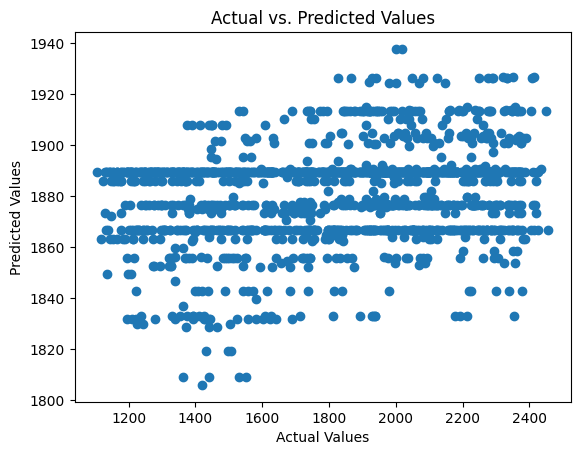

In [70]:
# Plotting actual vs predicted values to visualize how well our model is performing.
plt.scatter(Y_Test, predictionsGB)
plt.xlabel('Actual Values')  # X-axis label
plt.ylabel('Predicted Values')  # Y-axis label
plt.title('Actual vs. Predicted Values')  # Graph title
plt.show()  # Display the plot

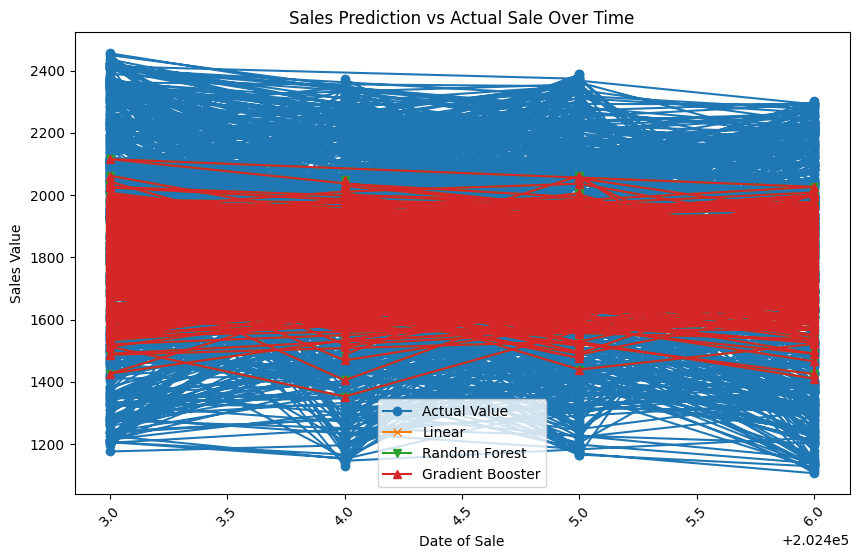

In [71]:
# Create the plot
from datetime import datetime
#X_Test['Date of Sale'] = pd.to_datetime(X_Test[['Year', 'Month', 'Day']])
#print(X_Test['Date of Sale'].head(10))

merged_df = pd.merge(X_Test, Y_Test, left_index=True, right_index=True)
#filtered_df = merged_df[merged_df['Store ID'] == 10100]
df_1d = pd.DataFrame(predictionsLR, columns=['Prediction'])
df_1d2 = pd.DataFrame(predictionsRF, columns=['PredictionRF'])
df_1d3 = pd.DataFrame(predictionsRF, columns=['PredictionGB'])
#df_1d3 = pd.DataFrame(predGB, columns=['PredictionGB'])
merged_df2 = pd.merge(X_Test, df_1d, left_index=True, right_index=True)
#filtered_df2 = merged_df2[merged_df2['Store ID'] == 10100]
merged_df3 = pd.merge(X_Test, df_1d2, left_index=True, right_index=True)
#filtered_df3 = merged_df3[merged_df3['Store ID'] == 10100]
merged_df4 = pd.merge(X_Test, df_1d3, left_index=True, right_index=True)
#filtered_df4 = merged_df4[merged_df4['Store ID'] == 10100]


#X_Test['Date of Sale'] = pd.to_datetime(str(X_Test['Year']) + '-' + str(X_Test['Month']) + '-' + str(X_Test['Day']))
plt.figure(figsize=(10, 6))  # Set the figure size= modelLR.predict(X_Test)
plt.plot(merged_df['YearMonth'] , merged_df['Units Sold'], label='Actual Value', marker='o')  # Plot Sales Prediction
plt.plot(merged_df2['YearMonth'] , merged_df2['Prediction'], label='Linear', marker='x')  # Plot Sales Prediction
plt.plot(merged_df3['YearMonth'] , merged_df3['PredictionRF'], label='Random Forest', marker='v')  # Plot Sales Prediction
plt.plot(merged_df4['YearMonth'] , merged_df4['PredictionGB'], label='Gradient Booster', marker='^')  # Plot Sales Prediction
#plt.plot(X_Test['Month'] , predictionLSTM, label='Long Term Short Memory', marker='x')  # Plot Sales Prediction

# Adding titles and labels
plt.title('Sales Prediction vs Actual Sale Over Time')
plt.xlabel('Date of Sale')
plt.ylabel('Sales Value')
plt.xticks(rotation=45)  # Rotate date labels for better readability

# Adding legend
plt.legend()

# Show the plot
plt.show()


In [72]:
print(X_Test)

      GDP Growth Rate  Inflation Rate  Price Sold  YearMonth  Price Sold  \
0               -2.00            2.21      496.69     202405      496.69   
1               -1.96            1.92      139.67     202403      139.67   
2               -1.96            1.92      323.47     202404      323.47   
3               -1.92            1.96      482.03     202406      482.03   
4               -1.87            1.96      363.15     202406      363.15   
...               ...             ...         ...        ...         ...   
1615             1.93            1.94      262.42     202404      262.42   
1616             1.96            2.00      191.99     202405      191.99   
1617             1.96            2.02      310.31     202403      310.31   
1618             1.96            2.02      407.47     202403      407.47   
1619             1.97            1.93      490.38     202406      490.38   

      Store ID_1  Store ID_2  Store ID_3  Store ID_4  Store ID_5  ...  \
0           Tr

#Merge the model results into a single dataframe and save this to csv in Google Drive

Not sure the ['Model'] field has any value.
Merge the Dataframes into a larger dataframe Save that DataFrame into a CSV file in Google Drive The new file will be accessed by Power BI for additional visualisations.

In [73]:
df_1d = pd.DataFrame(predictionsLR, columns=['Prediction'])
df_1d2 = pd.DataFrame(predictionsRF, columns=['PredictionRF'])
df_1d3 = pd.DataFrame(predictionsGB, columns=['PredictionGB'])
merged_df2 = pd.merge(X_Test, df_1d, left_index=True, right_index=True)
merged_df2['Model'] = 'Linear Regression'
merged_df3 = pd.merge(X_Test, df_1d2, left_index=True, right_index=True)
merged_df3['Model'] = 'Random Forest'
#merged_df4 = pd.merge(X_Test, df_1d3, left_index=True, right_index=True)
#merged_df3['Model'] = 'Gradient Boost'


# Merge all prediction DataFrames into one DataFrame
predictions_df = pd.concat([df_1d, df_1d2, df_1d3], axis=1)

# Merge X_Test with Y_Test
merged_df1 = pd.merge(X_Test, Y_Test, left_index=True, right_index=True)
merged_df1['Model'] = 'Actual'
# Now merge this with the combined predictions DataFrame
final_merged_df = pd.merge(merged_df1, predictions_df, left_index=True, right_index=True)

# If you need to display the final DataFrame
print(final_merged_df.head())

   GDP Growth Rate  Inflation Rate  Price Sold  YearMonth  Price Sold  \
0            -2.00            2.21      496.69     202405      496.69   
1            -1.96            1.92      139.67     202403      139.67   
2            -1.96            1.92      323.47     202404      323.47   
3            -1.92            1.96      482.03     202406      482.03   
4            -1.87            1.96      363.15     202406      363.15   

   Store ID_1  Store ID_2  Store ID_3  Store ID_4  Store ID_5  ...  \
0        True       False       False       False       False  ...   
1        True       False       False       False       False  ...   
2        True       False       False       False       False  ...   
3        True       False       False       False       False  ...   
4        True       False       False       False       False  ...   

   Product ID_41  Product ID_42  Product ID_43  Product ID_44  Product ID_45  \
0          False          False          False          Fals

#Save the DataFrames to CSV for access by Power BI

In [74]:
# Assuming 'filtered_df' is your DataFrame
final_merged_df.to_csv('gdrive/MyDrive/final_merged_df.csv', index=False)

#Future Steps
For this to be used in the business:
We need to be able to feed in new data and train on that data at regular intervals.  This would require a data ingestion process to take out the manual file creation.